# PCA Mathematics

In this section, we'll implement PCA ourselves, and then use sklearn's implementation. In practice, you will almost never want to run PCA yourself, and let other packages handle that for you.

Remember that PCA is performed as the **eigenvalue decomposition** of the **covariance matrix** of our data matrix X.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb #Comment this out if you don't have seaborn

from sklearn import datasets

%matplotlib inline

We'll start by making a dataset X with 2 features and 100 data samples.

In [4]:
a, b = datasets.make_regression(bias=1.0,n_informative=10,n_features=1,noise=10)
X = np.hstack((a, b.reshape(a.shape)))

In [6]:
X.shape

(100, 2)

(<matplotlib.text.Text at 0x101c35110>, <matplotlib.text.Text at 0x10a92bc10>)

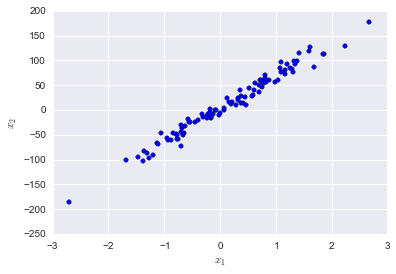

In [7]:
plt.scatter(X[:,0],X[:,1])
plt.xlabel(r"$x_1$"), plt.ylabel(r"$x_2$")

As you can see, most of the variation in the dataset occurs along the diagonal axis along $+x_1, +x_2$. You might imagine that the next orthogonal basis containing the most variation occurs along $-x_1, +x_2$.

Let's begin by calculating the covariance matrix. We will use sklearn.covariance, which can handle de-meaning of the data for us first.

In [8]:
# First have to demean each feature/column of X
X_demean = (X - np.mean(X,axis=0,keepdims=True)) / np.std(X,axis=0,keepdims=True)

#Double check
print "All 0 mean:", np.allclose(np.mean(X_demean,axis=0),0)
print "Shape X_demean:", X_demean.shape

print "All 1 var:", np.allclose(np.std(X_demean,axis=0),1)

All 0 mean: True
Shape X_demean: (100, 2)
All 1 var: True


(<matplotlib.text.Text at 0x105f45f50>, <matplotlib.text.Text at 0x10aa3e990>)

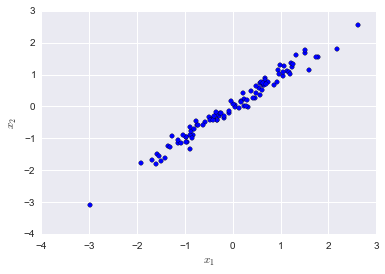

In [9]:
plt.scatter(X_demean[:,0],X_demean[:,1])
plt.xlabel(r"$x_1$"), plt.ylabel(r"$x_2$")

In [10]:
cov_mat = np.cov(X_demean,rowvar=0,bias=1) 

In [11]:
cov_mat

array([[ 1.        ,  0.98713271],
       [ 0.98713271,  1.        ]])

Next, we have to perform eigenvalue decomposition on the covariance matrix. This way, we can generate the principal component vectors (columns of eigenvector matrix). 

In [12]:
eig_val, eig_vec = np.linalg.eig(cov_mat) 
print eig_val
print eig_vec

[ 1.98713271  0.01286729]
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


PCA sorts the values (and their associated vectors) in decreasing order, but it seems the results of the eigen decomposition did not do that. Let's go ahead and resort in decreasing order of eigenvalue.

In [13]:
eig_vec = eig_vec[:,np.argsort(eig_val)[::-1] ] 
eig_val = eig_val[  np.argsort(eig_val)[::-1] ]

In [14]:
print eig_val
print eig_vec

[ 1.98713271  0.01286729]
[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


That's better.  Now, when we want to convert our original data matrix X into this "new" space, we can compute the operation:

$$ X_{transformed} = X * Q $$

where X is our original data matrix, and Q is the matrix of eigenvectors.

In [15]:
X_trans = X_demean.dot(eig_vec)

Let's plot what the data points look like in this new space. The scales are different, but theres clearly more variation along PC1 (first eigenvector), than there is along PC2 (second eigenvector)


(<matplotlib.text.Text at 0x10a8d2bd0>, <matplotlib.text.Text at 0x10afc4110>)

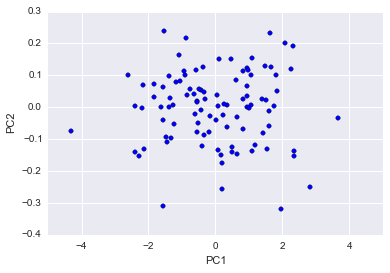

In [18]:
plt.scatter(X_trans[:,0],X_trans[:,1])
plt.xlabel("PC1"), plt.ylabel("PC2")

If we want to convert back to the original coordinates, we can compute the following operation:

$$ X_{reconstructed} = X_{transformed} * Q^T $$

where $Q^T$ is the tranpose of the eigenvector matrix, since:

$$ X_{reconstructed} = X * Q * Q^T = X * I$$

In [19]:
X_rec = X_trans.dot(eig_vec.T)

Let's just double check that this new reconstructed matrix is the same as the demeaned X matrix we were using.

All close: True


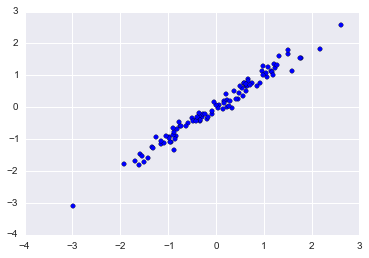

In [20]:
plt.scatter(X_rec[:,0],X_rec[:,1])

print "All close:", np.allclose(X_rec - X_demean,0)

All fun and good, but we're using PCA for a reason. Within our transformed space, we can effectively squash out a dimension if we wanted to. We can do this by effectively setting any number of the eigenvectors in our transformation to 0.

array([[ 0.70710678, -0.70710678],
       [ 0.70710678,  0.70710678]])

In [22]:
eig_vec_squash = eig_vec.copy()
eig_vec_squash[:,1] = 0 

# Reconstruct with a limited set of basis
X_rec_squash = X_trans.dot(eig_vec_squash.T)

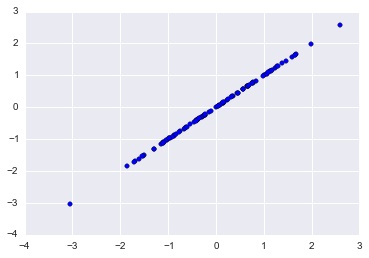

In [23]:
plt.scatter(X_rec_squash[:,0],X_rec_squash[:,1])

Really cool! We've essnetially removed most of the noise.

# SKLearn PCA

Let's see how SKLearn PCA makes it easy and does this all for us. In particular, there is a `n\_components` argument that directly tells PCA how many dimensions to keep in the new basis. By default, PCA will keep all of them.

In [24]:
from sklearn.decomposition import PCA

In [25]:
# Let's take a look at the arguments
pca_model = PCA()  
pca_model.fit(X_demean) 

PCA(copy=True, n_components=None, whiten=False)

In [26]:
print pca_model.explained_variance_ #sorted eigenvalues
print pca_model.components_.T #sorted Eigenvectors -- components_ matrix is in form of #components x #features

[ 1.98713271  0.01286729]
[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]


In [27]:
X_trans = pca_model.transform(X_demean)
X_trans.shape

(100, 2)

In [28]:
# X -> trans -> inv trans == X ?? Its true
np.allclose(X_demean.dot(pca_model.components_).dot(pca_model.components_.T) - X_demean,0)

True

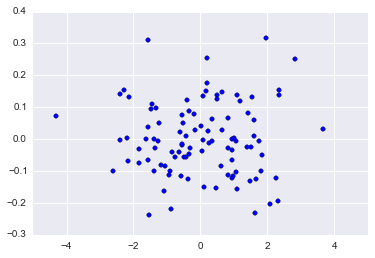

In [29]:
plt.scatter(X_trans[:,0],X_trans[:,1])

All close: True


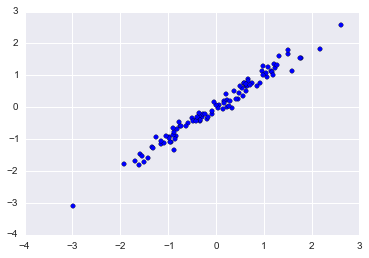

In [30]:
X_rec = pca_model.inverse_transform(X_trans)
plt.scatter(X_rec[:,0],X_rec[:,1])
print "All close:", np.allclose(X_rec - X_demean, 0)

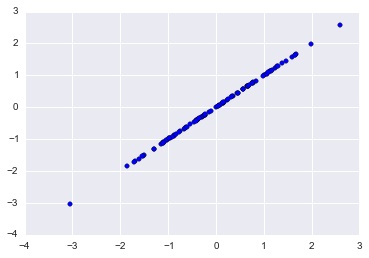

In [35]:
pca_model = PCA(n_components=1)

X_reduced = pca_model.inverse_transform(pca_model.fit_transform(X_demean))
plt.scatter(X_reduced[:,0],X_reduced[:,1])

In [34]:
X_reduce

array([[-1.14638402, -1.14638402],
       [-0.53636075, -0.53636075],
       [-1.51055377, -1.51055377],
       [-0.66750516, -0.66750516],
       [ 1.2317673 ,  1.2317673 ],
       [-3.04493147, -3.04493147],
       [-1.10429596, -1.10429596],
       [ 0.76831667,  0.76831667],
       [-0.87251584, -0.87251584],
       [-0.88682529, -0.88682529],
       [-0.30112231, -0.30112231],
       [-1.02540491, -1.02540491],
       [ 1.13240442,  1.13240442],
       [-0.61938037, -0.61938037],
       [-0.38015851, -0.38015851],
       [ 0.65718946,  0.65718946],
       [-0.41374345, -0.41374345],
       [-1.6892071 , -1.6892071 ],
       [-0.31373974, -0.31373974],
       [ 0.99971249,  0.99971249],
       [ 0.65772553,  0.65772553],
       [ 1.58588752,  1.58588752],
       [ 0.83630999,  0.83630999],
       [-0.23314904, -0.23314904],
       [ 0.14767789,  0.14767789],
       [-1.85404261, -1.85404261],
       [-0.82739788, -0.82739788],
       [ 0.57205386,  0.57205386],
       [ 1.28199851,

# Exercise: Olivetti Faces

In this example, we are going to use the olivetti faces dataset to perform some PCA and dimesionality reduction.

The dataset contains 400 images, each of which is 64 x 64 pixels. The pixels have been concattenated, so that we have a final matrix of 400 x 4096, where each row corresponds to one image.

We are going to find new basis under which we can describe these images. 

In [36]:
faces = datasets.fetch_olivetti_faces()
print faces.DESCR

Modified Olivetti faces dataset.

The original database was available from (now defunct)

    http://www.uk.research.att.com/facedatabase.html

The version retrieved here comes in MATLAB format from the personal
web page of Sam Roweis:

    http://www.cs.nyu.edu/~roweis/

There are ten different images of each of 40 distinct subjects. For some
subjects, the images were taken at different times, varying the lighting,
facial expressions (open / closed eyes, smiling / not smiling) and facial
details (glasses / no glasses). All the images were taken against a dark
homogeneous background with the subjects in an upright, frontal position (with
tolerance for some side movement).

The original dataset consisted of 92 x 112, while the Roweis version
consists of 64x64 images.



In [37]:
X = faces.data
X_demean = (X - np.mean(X,axis=0,keepdims=True))

Let's see what one of these faces look like. Remember that the images have been demeaned, so the 'brightness' of each image will be lower than natural.

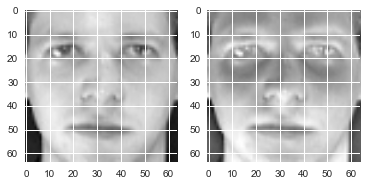

In [42]:
# Original example face
plt.subplot(1,2,1)
plt.imshow(X[0,:].reshape((64,64)),cmap=plt.cm.gray)

# Demeaned example face
plt.subplot(1,2,2)
plt.imshow(X_demean[0,:].reshape((64,64)),cmap=plt.cm.gray)

Your current X_demean matrix is size 400 x 4096 -- There are 400 different faces, and 4096 ( 64 x 64 ) features/pixels per face.

* Perform PCA on the X_demean matrix. 
* Plot the cumulative sum of the pca\_model.explained\_variance\_ratio\_. The explained variance ratio is a percentage of the total explainable variance that is explained by a particular principal components.

In [ ]:
pca_model = PCA() 
pca_model.fit(X_demean)

In [ ]:
plt.plot(np.cumsum(pca_model.explained_variance_ratio_))

Look at about how many components at which the curve starts to flatten out. In my case, I saw that most of the variance was explained by 50-100 principal components.

* Now, build a new PCA model and set 'n_components' to the number you saw for explaining a good chunk of the variance (or you can choose 100).
* Fit and transform your X_demean matrix, save it as X_trans.
* Call the `inverse_transform` function on your model and pass in the X_trans matrix. Save this new one as X_reduced.
* Plot the first image (i.e. first row) of X_reduced. You may need to reshape it into a 64x64 image.


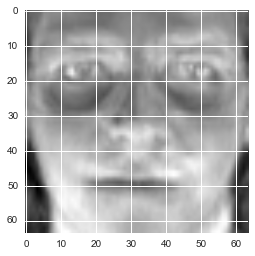

In [44]:
pca_model = PCA(n_components=100 ) 
X_trans = pca_model.fit_transform(X_demean) 
X_reduced = pca_model.inverse_transform(X_trans)
plt.imshow( X_reduced[0,:].reshape((64,64)),cmap=plt.cm.gray)

## More Exercises

- Play around with reconstructing the original faces. How many components would you generally need to recognize the face yourself? (A liberal estimate would suffice.)
- Play around with `n_components`, `whiten=True/False` to see different results of the facial recognition
- Try fitting only on a few of the original faces (perhaps a 300x4096) matrix. Then see how close the other 100 faces look after they've been transformed and inverse_transformed.
- Try imshow on 16 of the pca_model.components\_. The are the "new basis" features with which each image can be created. The 0th component, or PC1 is the "most average face"

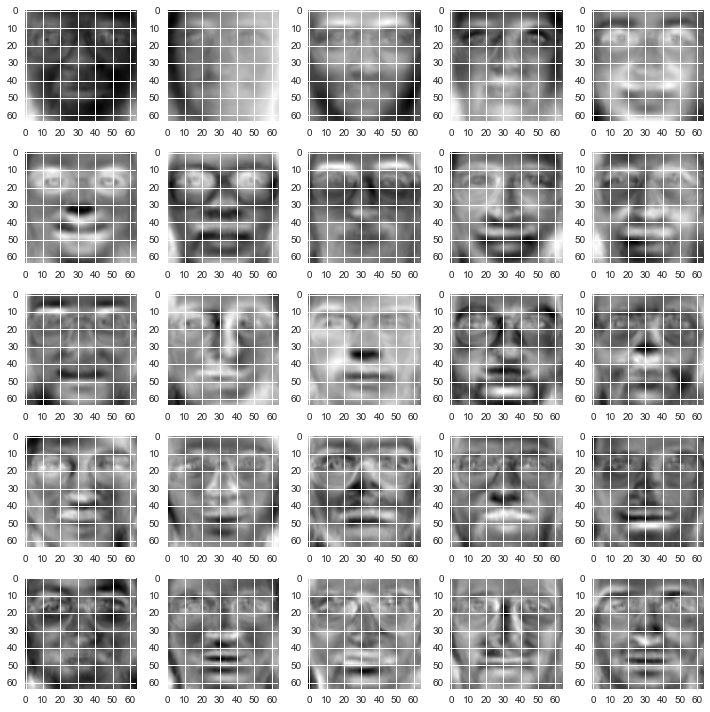

In [45]:
plt.figure(figsize=(10,10))

for idx in range(25):
    plt.subplot(5,5,idx+1)
    plt.imshow(pca_model.components_[idx,:].reshape((64,64)),cmap=plt.cm.gray)
plt.tight_layout()

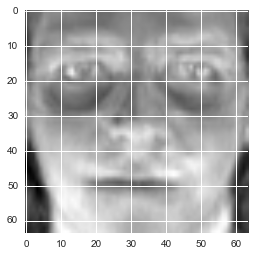

In [53]:
# Our guy's face is the first row of the transformed face x the pca component vectors
# I.e. -6.4 * face1 - .703 * face2 - 1.43 * face3 + 1.278 * face 4 + ...

plt.imshow(
    pca_model.transform(X_demean)[0,:].dot(pca_model.components_).reshape((64,64)),
    cmap=plt.cm.gray
    )